In [1]:
# Ran in Colab

In [45]:
import pandas as pd
from datetime import datetime

# Allow uploads/dowloads of files in Colab
from google.colab import files

# Language processing imports, Colab requires explicit downloads for some nltk resources
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Model and evaluation imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Visualization imports
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data importation
Technical difficulties prevented me from importing full dataset.  I was able to open the provided csv in Excel, export it as a new csv specified to be encoded in UTC-8, and then import that new csv in Jupyter Lab successfully. This limited the dataset to 1M lines, removing some 600,000 rows. This should still be a sizable dataset for analysis. However, as the original data was ordered by sentiment, this removed a significant amount of positive sentimented text.

In [5]:
# Upload the dataset from local storage

uploaded = files.upload()

Saving training8.csv to training8 (1).csv


In [57]:
# import dataset from csv
tweets_df = pd.read_csv('training8.csv', header=None, names=["sentiment", "id", "time", "query", "name", "text"])
tweets_df.head()

,sentiment,id,time,query,name,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [58]:
#Does column 'NO_QUERY' contain any useful data or is every row just 'NO_QUERY'?
tweets_df['query'].value_counts()

NO_QUERY    1000000
Name: query, dtype: int64

In [59]:
#What's going on with sentiment values?
tweets_df['sentiment'].value_counts()

0    800000
4    200000
Name: sentiment, dtype: int64

In [60]:
# Perharps all sentiments of 2 and 3 were excluded in processing?
# Reset '4' to '1' to indicate binary sentiment
tweets_df['sentiment'] = tweets_df['sentiment'].replace('4', '1')

In [61]:
# Tweet 'id', 'query', and 'name' columns are unlikely to be useful for sentiment analysis. There could be something in 'time,' but
# without timezone data it can't be determined what time of day tweets were sent.
# I'll keep 'time' for potential use in a time series visualization.
tweets_df = tweets_df.drop(columns=['id', 'query', 'name'])
tweets_df.head()

,sentiment,time,text
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all...."


In [62]:
# Process text for use in modeling

# Lemmatizer script
lemmatizer = WordNetLemmatizer()

def process_text(text):
    # remove 'stopwords' ie "the, a, on" etc
    sw = set(stopwords.words('english'))

    # remove all special characters ie everything except letters and spaces
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)

    # seperate back into words
    words = word_tokenize(re_clean)

    # take lemma of each word ie "runs, ran, running" all become "run"
    lem = [lemmatizer.lemmatize(word) for word in words]

    # rejoin all lemmas back into strings for each row. return in lowercase
    output = ' '.join([word.lower() for word in lem if word.lower() not in sw])

    return output

In [63]:
# Apply to source data
tweets_df['text'] = tweets_df['text'].apply(lambda x: process_text(x))

In [13]:
tweets_df.head()

,sentiment,time,text
0,0,Mon Apr 06 22:19:45 PDT 2009,switchfoot httptwitpiccomyzl awww thats bummer...
1,0,Mon Apr 06 22:19:49 PDT 2009,upset cant update facebook texting might cry r...
2,0,Mon Apr 06 22:19:53 PDT 2009,kenichan dived many time ball managed save res...
3,0,Mon Apr 06 22:19:57 PDT 2009,whole body feel itchy like fire
4,0,Mon Apr 06 22:19:57 PDT 2009,nationwideclass behaving im mad cant see


In [14]:
tweets_df['text'][0]

'switchfoot httptwitpiccomyzl awww thats bummer shoulda got david carr third day'

## Feature Extraction

In [15]:
# TF-IDF feature extraction to transform the text data into numerical features.
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(tweets_df['text'])
y = tweets_df['sentiment']
X

<1000000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 6159706 stored elements in Compressed Sparse Row format>

## Model Training

In [16]:
# Train-test split, test 20% of total
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Create and train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(n_estimators=10, random_state=42)

## Model evaluation

In [18]:
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)


In [19]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.83348
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90    160075
           4       0.67      0.32      0.44     39925

    accuracy                           0.83    200000
   macro avg       0.76      0.64      0.67    200000
weighted avg       0.82      0.83      0.81    200000

Confusion Matrix:
 [[153790   6285]
 [ 27019  12906]]


## Sentiment Analysis: How do people on Twitter feel about Twitter?

In [64]:
# Extract rows with text referring to 'twitter' to new dataframe
keyword = 'twitter'
mention = tweets_df['text'].apply(lambda x: keyword in x)
twitter_df = tweets_df[mention]


In [65]:
twitter_df.head()

,sentiment,time,text
9,0,Mon Apr 06 22:20:09 PDT 2009,twittera que muera
224,0,Mon Apr 06 22:35:41 PDT 2009,miss twitter phone broke im using stupid nokia...
231,0,Mon Apr 06 22:35:50 PDT 2009,charlietm know right dunno going twitter
562,0,Mon Apr 06 22:57:59 PDT 2009,chordsy last find thing like youre twitter
606,0,Mon Apr 06 23:01:54 PDT 2009,morning folk yawn amp away see horse hope twit...


## Visualizations

Text(0.5, 1.0, 'WordCloud of all tweets')

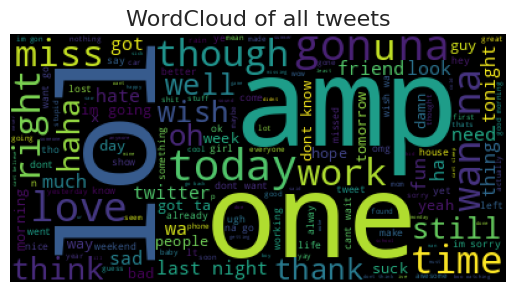

In [51]:
# WordCloud of total tweets

# tweets_df['text'] corpus has already been lemmatized by process_text function appropriately for WordCloud,
# just needs to be rejoined into one big string (?)
big_string = ' '.join(tweets_df['text'])
wc = WordCloud().generate(big_string)
plt.imshow(wc)
plt.axis("off")  # Turn off axis labels for better visualization
plt.title("WordCloud of all tweets", fontsize=16) # Add title using MatPlotLib


In [52]:
# Save WordCloud as PNG image
wc.to_file("all_tweets_wc.png")

# Download file
files.download("all_tweets_wc.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
# WordCloud of tweets mentioning 'twitter' (excluding the word 'twitter')

# Exclude the word 'twitter' itself  and related words from 'text' of twitter_df
# Define words to exclude
words_to_exclude = ['twitter', 'tweets', 'tweet', 'tweeting']

# Define function to exclude these words
def exclude_words(text, words_to_exclude):
    for word in words_to_exclude:
        text = text.replace(word, '')
    return text


In [72]:
# Apply function
# Create new dataframe to not alter twitter_df
twitter_cleaned_df = twitter_df.copy()

twitter_cleaned_df['text'] = twitter_df['text'].apply(exclude_words, words_to_exclude=words_to_exclude)

Text(0.5, 1.0, 'WordCloud of all tweets mentioning Twitter')

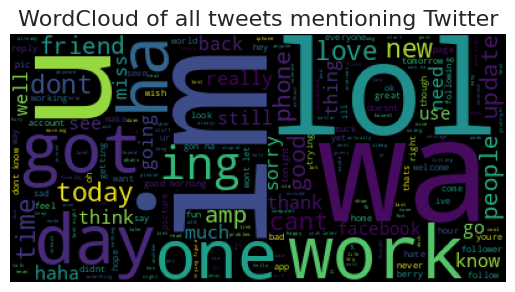

In [73]:
# Create WordCloud of tweets that refer to 'twitter,' but excluding the word 'twitter' itself

big_string = ' '.join(twitter_cleaned_df['text'])
wc = WordCloud().generate(big_string)
plt.imshow(wc)
plt.axis("off")  # Turn off axis labels for better visualization
plt.title("WordCloud of all tweets mentioning Twitter", fontsize=16) # Add title using MatPlotLib

In [74]:
# Save WordCloud as PNG image
wc.to_file("twitter_tweets_wc.png")

# Download file
files.download("twitter_tweets_wc.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:

# Create a 'day' column to hold a datetime formatted version of 'time', excluding timescales finer than a day
twitter_df['time_formatted'] = pd.to_datetime(twitter_df['time'], infer_datetime_format=True).dt.date

# Group by the day and calculate the mean sentiment for each day
daily_sentiment = twitter_df.groupby('day')['sentiment'].mean().reset_index()

# Sort by day
daily_sentiment = daily_sentiment.sort_values(by='day')

daily_sentiment.head()


/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
<ipython-input-44-18399fadb78e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['time_formatted'] = pd.to_datetime(twitter_df['time'], infer_datetime_format=True).dt.date


,day,sentiment
0,2009-04-06,2.976000
1,2009-04-07,2.757475
2,2009-04-17,2.969697
3,2009-04-18,2.787330
4,2009-04-19,2.966667


<Axes: title={'center': 'Twitter Sentiment by Day'}, xlabel='day'>

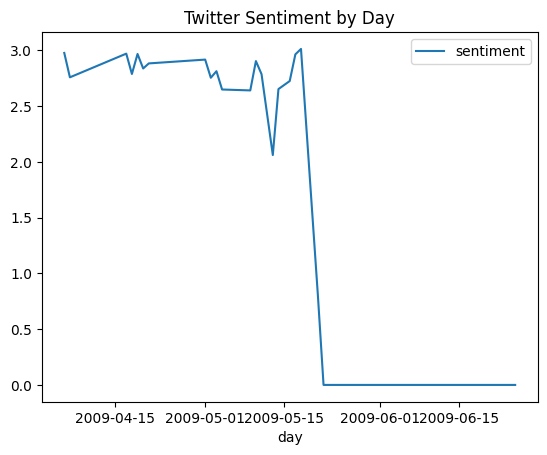

In [43]:
daily_sentiment.plot(kind='line', x='day', y='sentiment', title='Twitter Sentiment by Day')

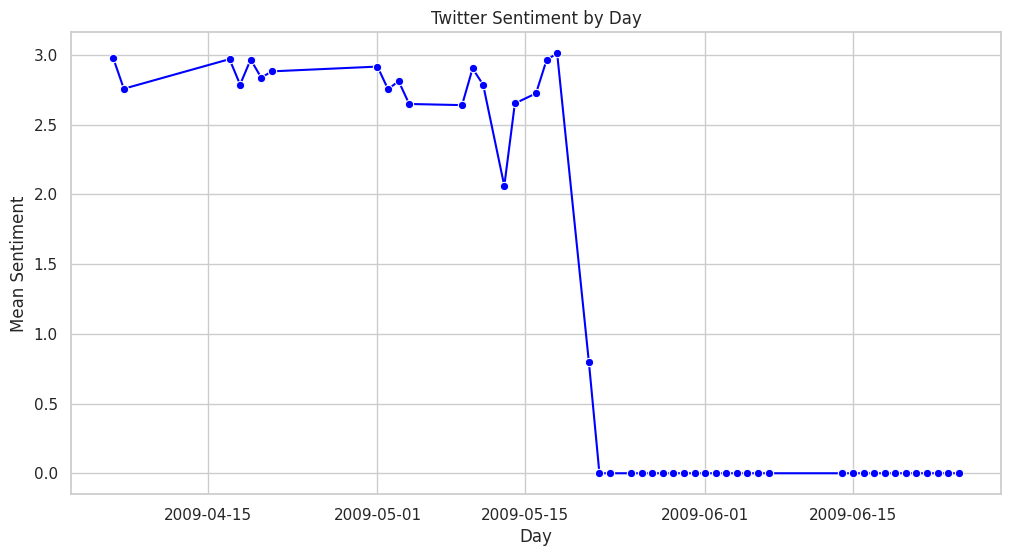

In [47]:
# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a line plot using Seaborn
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
sns.lineplot(x='day', y='sentiment', data=daily_sentiment, marker='o', color='blue')

# Set plot title and labels
plt.title('Twitter Sentiment by Day')
plt.xlabel('Day')
plt.ylabel('Mean Sentiment')

# Save the plot
plt.savefig('twitter_sentiment_by_day.png')

# Show the plot
plt.show()

In [48]:
# Download the saved image file to local storage
files.download('twitter_sentiment_by_day.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>